In [2]:
from datasets import load_dataset

ds = load_dataset("jxm/mpqa")

In [1]:
!pip install pennylane
# =====================================
# 1. Imports
# =====================================
import re, warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pennylane as qml

from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================================
# 2. Load Dataset (Binary Sentiment)
# =====================================
ds = load_dataset("jxm/mpqa")
# Convert train split to pandas (MPQA already split)
df = ds["train"].to_pandas()

print("Dataset shape:", df.shape)

# =====================================
# 3. Preprocessing
# =====================================
# ===============================
# Dataset Preprocessing
# ===============================
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

df["cleaned_text"] = df["sentence"].astype(str).apply(clean_text)

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])
min_class = df["label"].value_counts().min()

# Balance classes
df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(min_class, random_state=42))
      .sample(frac=1, random_state=42)
)

# =====================================
# 4. Tokenization
# =====================================
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

tokens = tokenizer(
    df["cleaned_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df["label"].values)

X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    input_ids, labels, attention_mask,
    test_size=0.2, random_state=42
)

train_data = TensorDataset(X_train, m_train, y_train)
val_data   = TensorDataset(X_val, m_val, y_val)

# =====================================
# 5. Quantum Circuits
# =====================================
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def qc1(weights, x):
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([0, 1])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc2(weights, x):
    qml.Hadamard(0)
    qml.RY(x[0], 0)
    qml.RX(x[1], 1)
    qml.CNOT([1, 0])
    qml.RX(weights[0], 0)
    qml.RY(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc3(weights, x):
    for i in range(2):
        qml.Hadamard(i)
        qml.RX(x[i], i)
        qml.RY(weights[i], i)
        qml.RZ(weights[i], i)
    qml.CNOT([0, 1])
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev, interface="torch")
def qc4(weights, x):
    qml.Hadamard(0)
    qml.CNOT([0, 1])
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([1, 0])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

QUANTUM_CIRCUITS = {
    "QC1": qc1,
    "QC2": qc2,
    "QC3": qc3,
    "QC4": qc4
}

# =====================================
# 6. QBiLSTM Model
# =====================================
class QBiLSTM(nn.Module):
    def __init__(self, quantum_circuit):
        super().__init__()

        self.qc = quantum_circuit
        self.q_weights = nn.Parameter(torch.randn(2))

        self.encoder = AutoModel.from_pretrained("microsoft/deberta-v3-base")

        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(257, 2)

    def quantum_layer(self, x):
        q_out = [self.qc(self.q_weights, v[:2]) for v in x]
        q_out = torch.stack(q_out)
        q_out = q_out.float()
        return q_out.unsqueeze(1)

    def forward(self, input_ids, attention_mask):
        enc = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state

        lstm_out, _ = self.bilstm(enc)
        h = lstm_out[:, -1, :]

        q_feat = self.quantum_layer(h)
        h = torch.cat([h, q_feat], dim=1)

        return self.fc(h)

# =====================================
# 7. Training + Evaluation
# =====================================
def train_and_validate(model, params):

    train_loader = DataLoader(train_data, batch_size=params["batch_size"], shuffle=True)
    val_loader   = DataLoader(val_data, batch_size=params["batch_size"])

    optimizer = AdamW(model.parameters(), lr=params["learning_rate"])
    loss_fn = nn.CrossEntropyLoss()

    total_steps = len(train_loader) * params["epochs"]
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 0, total_steps
    )

    # Training
    for _ in range(params["epochs"]):
        model.train()
        for ids, mask, y in train_loader:
            ids, mask, y = ids.to(device), mask.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(ids, mask)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()
            scheduler.step()

    # Evaluation
    model.eval()
    preds, gold, probs = [], [], []

    with torch.no_grad():
        for ids, mask, y in val_loader:
            ids, mask = ids.to(device), mask.to(device)
            logits = model(ids, mask)

            softmax = torch.softmax(logits, dim=1)
            preds.extend(torch.argmax(logits, 1).cpu().numpy())
            probs.extend(softmax[:,1].cpu().numpy())
            gold.extend(y.numpy())

    acc = accuracy_score(gold, preds)
    prec = precision_score(gold, preds)
    recall = recall_score(gold, preds)
    f1 = f1_score(gold, preds)
    auc = roc_auc_score(gold, probs)

    tn, fp, fn, tp = confusion_matrix(gold, preds).ravel()
    specificity = tn / (tn + fp)

    return acc, prec, recall, specificity, f1, auc

# =====================================
# 8. Run All 4 Models
# =====================================
params = {
    "learning_rate": 2e-5,
    "batch_size": 16,
    "epochs": 5
}

final_results = {}

for name, qc in QUANTUM_CIRCUITS.items():
    print(f"\n===== Training {name} =====")

    model = QBiLSTM(qc).to(device)
    metrics = train_and_validate(model, params)

    final_results[name] = metrics

# =====================================
# 9. Final Comparison
# =====================================
print("\n===== FINAL RESULTS =====")
print("Model | Accuracy | Precision | Sensitivity | Specificity | F1 | AUC")

for k, v in final_results.items():
    print(f"{k} | {v[0]:.4f} | {v[1]:.4f} | {v[2]:.4f} | {v[3]:.4f} | {v[4]:.4f} | {v[5]:.4f}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 88.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 80.3 MB/s eta 0:00:00:00:0100:01


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


README.md:   0%|          | 0.00/650 [00:00<?, ?B/s]

data/train-00000-of-00001-a7df005a1b0788(…):   0%|          | 0.00/141k [00:00<?, ?B/s]

data/test-00000-of-00001-05fc5ca1c399669(…):   0%|          | 0.00/33.7k [00:00<?, ?B/s]

data/dev-00000-of-00001-8814a3252cc44468(…):   0%|          | 0.00/6.19k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8603 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/256 [00:00<?, ? examples/s]

Dataset shape: (8603, 2)


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]


===== Training QC1 =====


2026-02-16 12:46:07.660007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771245967.980396      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771245968.072836      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771245968.888102      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771245968.888155      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771245968.888158      55 computation_placer.cc:177] computation placer alr

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]


===== Training QC2 =====

===== Training QC3 =====

===== Training QC4 =====

===== FINAL RESULTS =====
Model | Accuracy | Precision | Sensitivity | Specificity | F1 | AUC
QC1 | 0.8800 | 0.8645 | 0.9034 | 0.8562 | 0.8835 | 0.9285
QC2 | 0.5946 | 0.5569 | 0.9549 | 0.2288 | 0.7036 | 0.7080
QC3 | 0.4962 | 0.0000 | 0.0000 | 1.0000 | 0.0000 | 0.7022
QC4 | 0.7135 | 0.6489 | 0.9399 | 0.4837 | 0.7677 | 0.8502


In [3]:
!pip install pennylane
# =========================
# 1. Imports
# =========================
import re, time, random, warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

import nltk
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# =========================
# 3. Tokenization
# =========================
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

tokens = tokenizer(
    df["cleaned_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df["label"].values)

X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    input_ids, labels, attention_mask, test_size=0.2, random_state=42
)

train_data = TensorDataset(X_train, m_train, y_train)
val_data   = TensorDataset(X_val, m_val, y_val)

# =========================
# 4. Quantum Circuits
# =========================
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def qc1(weights, x):
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([0, 1])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc2(weights, x):
    qml.Hadamard(0)
    qml.RY(x[0], 0)
    qml.RX(x[1], 1)
    qml.CNOT([1, 0])
    qml.RX(weights[0], 0)
    qml.RY(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch")
def qc3(weights, x):
    for i in range(2):
        qml.Hadamard(i)
        qml.RX(x[i], i)
        qml.RY(weights[i], i)
        qml.RZ(weights[i], i)
    qml.CNOT([0, 1])
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev, interface="torch")
def qc4(weights, x):
    qml.Hadamard(0)
    qml.CNOT([0, 1])
    qml.RX(x[0], 0)
    qml.RY(x[1], 1)
    qml.CNOT([1, 0])
    qml.RZ(weights[0], 0)
    qml.RZ(weights[1], 1)
    return qml.expval(qml.PauliZ(0))

QUANTUM_CIRCUITS = {
    "QC1": qc1,
    "QC2": qc2,
    "QC3": qc3,
    "QC4": qc4
}

# =========================
# 5. QBiLSTM Model
# =========================
class QBiLSTM(nn.Module):
    def __init__(self, quantum_circuit):
        super().__init__()
        self.qc = quantum_circuit
        self.q_weights = nn.Parameter(torch.randn(2))

        self.encoder = AutoModel.from_pretrained("microsoft/deberta-v3-base")

        self.bilstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(257, 2)  # 256 + quantum feature

    def quantum_layer(self, x):
        q_out = [self.qc(self.q_weights, v[:2]) for v in x]
        q_out = torch.stack(q_out).unsqueeze(1)
        return q_out.float()

    def forward(self, input_ids, attention_mask):
        enc = self.encoder(input_ids, attention_mask).last_hidden_state
        lstm_out, _ = self.bilstm(enc)
        h = lstm_out[:, -1, :]

        q_feat = self.quantum_layer(h)
        h = torch.cat([h, q_feat], dim=1)

        return self.fc(h)

# =========================
# 6. Training Function
# =========================
def train_and_validate(model, params):
    train_loader = DataLoader(
        train_data, sampler=RandomSampler(train_data),
        batch_size=params["batch_size"]
    )
    val_loader = DataLoader(
        val_data, sampler=SequentialSampler(val_data),
        batch_size=params["batch_size"]
    )

    optimizer = AdamW(model.parameters(), lr=params["learning_rate"])
    loss_fn = nn.CrossEntropyLoss()

    total_steps = len(train_loader) * params["epochs"]
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 0, total_steps
    )

    for _ in range(params["epochs"]):
        model.train()
        for ids, mask, y in train_loader:
            ids, mask, y = ids.to(device), mask.to(device), y.to(device)

            optimizer.zero_grad()
            loss = loss_fn(model(ids, mask), y)
            loss.backward()
            optimizer.step()
            scheduler.step()

    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for ids, mask, y in val_loader:
            ids, mask = ids.to(device), mask.to(device)
            logits = model(ids, mask)
            preds.extend(torch.argmax(logits, 1).cpu().numpy())
            gold.extend(y.numpy())

    return accuracy_score(gold, preds)

# =========================
# 7. Hyperparameter Search
# =========================
param_grid = {
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "batch_size": [16, 32],
    "epochs": [3, 5]
}

param_list = list(ParameterSampler(param_grid, n_iter=5, random_state=42))

final_results = {}

for name, qc in QUANTUM_CIRCUITS.items():
    print(f"\n===== {name} =====")

    best_acc = 0
    best_params = None

    for params in param_list:
        model = QBiLSTM(qc).to(device)
        acc = train_and_validate(model, params)

        print(f"{params} → Acc: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = params

    final_results[name] = (best_acc, best_params)

# =========================
# 8. Final Results
# =========================
print("\n===== FINAL COMPARISON =====")
for k, (acc, params) in final_results.items():
    print(f"{k}: Accuracy = {acc:.4f}, Params = {params}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



===== QC1 =====
{'learning_rate': 2e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.5859
{'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.7178
{'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 16} → Acc: 0.6551
{'learning_rate': 3e-05, 'epochs': 3, 'batch_size': 32} → Acc: 0.5881
{'learning_rate': 3e-05, 'epochs': 5, 'batch_size': 16} → Acc: 0.6476

===== QC2 =====
{'learning_rate': 2e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.8659
{'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.4962
{'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 16} → Acc: 0.7535
{'learning_rate': 3e-05, 'epochs': 3, 'batch_size': 32} → Acc: 0.5038
{'learning_rate': 3e-05, 'epochs': 5, 'batch_size': 16} → Acc: 0.8768

===== QC3 =====
{'learning_rate': 2e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.7773
{'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 32} → Acc: 0.7178
{'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 16} → Acc: 0.5384
{'learning_rate': 3e-05, 'epochs': 3, '

In [4]:
epochs = 5
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32]
optimizers = ['adamw', 'adam', 'rmsprop', 'sgd']
num_samples = 5
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def get_optimizer(optimizer_name, model_parameters, lr):
    if optimizer_name == 'adamw':
        return optim.AdamW(model_parameters, lr=lr)
    elif optimizer_name == 'adam':
        return optim.Adam(model_parameters, lr=lr)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_parameters, lr=lr)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_parameters, lr=lr)
final_results = {}

for qc_name, qc in QUANTUM_CIRCUITS.items():
    print(f"\n==============================")
    print(f" Quantum Circuit: {qc_name}")
    print(f"==============================")

    best_accuracy = 0
    best_params = None

    # Random hyperparameter sampling
    random_hyperparams = [
        {
            "optimizer": random.choice(optimizers),
            "learning_rate": random.choice(learning_rates),
            "batch_size": random.choice(batch_sizes),
        }
        for _ in range(num_samples)
    ]

    for params in random_hyperparams:
        optimizer_name = params["optimizer"]
        lr = params["learning_rate"]
        batch_size = params["batch_size"]

        print(f"\n Testing {params}")

        # Fresh model for each trial (VERY IMPORTANT)
        model = QBiLSTM(qc).to(device)

        train_dataloader = DataLoader(
            train_data,
            sampler=RandomSampler(train_data),
            batch_size=batch_size
        )

        val_dataloader = DataLoader(
            val_data,
            sampler=SequentialSampler(val_data),
            batch_size=batch_size
        )

        optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
        loss_fn = nn.CrossEntropyLoss()

        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # ===== Training =====
        for epoch in range(epochs):
            model.train()
            total_train_loss = 0
            total_train_accuracy = 0

            for batch in train_dataloader:
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_labels = b_labels.to(device)

                optimizer.zero_grad()
                outputs = model(b_input_ids, b_input_mask)
                loss = loss_fn(outputs, b_labels)

                total_train_loss += loss.item()
                logits = outputs.detach().cpu().numpy()
                total_train_accuracy += flat_accuracy(logits, b_labels.cpu().numpy())

                loss.backward()
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_train_loss / len(train_dataloader)
            avg_train_accuracy = total_train_accuracy / len(train_dataloader)

            # ===== Validation =====
            model.eval()
            total_val_accuracy = 0
            total_val_loss = 0

            with torch.no_grad():
                for batch in val_dataloader:
                    b_input_ids, b_input_mask, b_labels = batch
                    b_input_ids = b_input_ids.to(device)
                    b_input_mask = b_input_mask.to(device)
                    b_labels = b_labels.to(device)

                    outputs = model(b_input_ids, b_input_mask)
                    loss = loss_fn(outputs, b_labels)

                    total_val_loss += loss.item()
                    logits = outputs.detach().cpu().numpy()
                    total_val_accuracy += flat_accuracy(logits, b_labels.cpu().numpy())

            avg_val_accuracy = total_val_accuracy / len(val_dataloader)

            print(
                f"Epoch {epoch+1} | "
                f"Train Acc: {avg_train_accuracy:.4f} | "
                f"Val Acc: {avg_val_accuracy:.4f}"
            )

        # ===== Track best =====
        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            best_params = {
                "optimizer": optimizer_name,
                "learning_rate": lr,
                "batch_size": batch_size
            }

    final_results[qc_name] = {
        "best_accuracy": best_accuracy,
        "best_params": best_params
    }

    print(f"\n BEST for {qc_name}: {best_accuracy:.4f}")
    print(f" PARAMS: {best_params}")

print("\n===== FINAL QUANTUM CIRCUIT COMPARISON =====")
for qc, res in final_results.items():
    print(
        f"{qc} | Accuracy: {res['best_accuracy']:.4f} | "
        f"Params: {res['best_params']}"
    )


 Quantum Circuit: QC1

 Testing {'optimizer': 'sgd', 'learning_rate': 3e-05, 'batch_size': 16}
Epoch 1 | Train Acc: 0.5216 | Val Acc: 0.5561
Epoch 2 | Train Acc: 0.5434 | Val Acc: 0.5540
Epoch 3 | Train Acc: 0.5536 | Val Acc: 0.5710
Epoch 4 | Train Acc: 0.5609 | Val Acc: 0.5787
Epoch 5 | Train Acc: 0.5733 | Val Acc: 0.5798

 Testing {'optimizer': 'sgd', 'learning_rate': 2e-05, 'batch_size': 32}
Epoch 1 | Train Acc: 0.4876 | Val Acc: 0.4918
Epoch 2 | Train Acc: 0.5049 | Val Acc: 0.4939
Epoch 3 | Train Acc: 0.5011 | Val Acc: 0.4971
Epoch 4 | Train Acc: 0.5033 | Val Acc: 0.4939
Epoch 5 | Train Acc: 0.5261 | Val Acc: 0.4928

 Testing {'optimizer': 'sgd', 'learning_rate': 5e-05, 'batch_size': 32}
Epoch 1 | Train Acc: 0.5029 | Val Acc: 0.5637
Epoch 2 | Train Acc: 0.5336 | Val Acc: 0.4962
Epoch 3 | Train Acc: 0.5480 | Val Acc: 0.5959
Epoch 4 | Train Acc: 0.5712 | Val Acc: 0.6150
Epoch 5 | Train Acc: 0.5666 | Val Acc: 0.6088

 Testing {'optimizer': 'adamw', 'learning_rate': 3e-05, 'batch_size


Evaluating BEST model for QC1

Evaluating BEST model for QC2

Evaluating BEST model for QC3

Evaluating BEST model for QC4

===== FINAL PERFORMANCE COMPARISON =====
Model | Accuracy | Precision | Sensitivity | Specificity | F1 | AUC
---------------------------------------------------------------------------
QC1 | 0.8443 | 0.8447 | 0.8442 | 0.8442 | 0.8442 | 0.8924
QC2 | 0.5546 | 0.5612 | 0.5557 | 0.5557 | 0.5449 | 0.7097
QC3 | 0.5881 | 0.6347 | 0.5858 | 0.5858 | 0.5459 | 0.6467
QC4 | 0.8605 | 0.8613 | 0.8607 | 0.8607 | 0.8605 | 0.8739


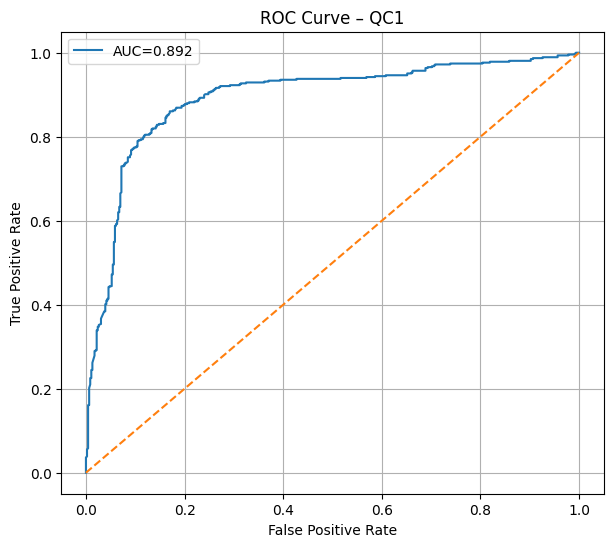

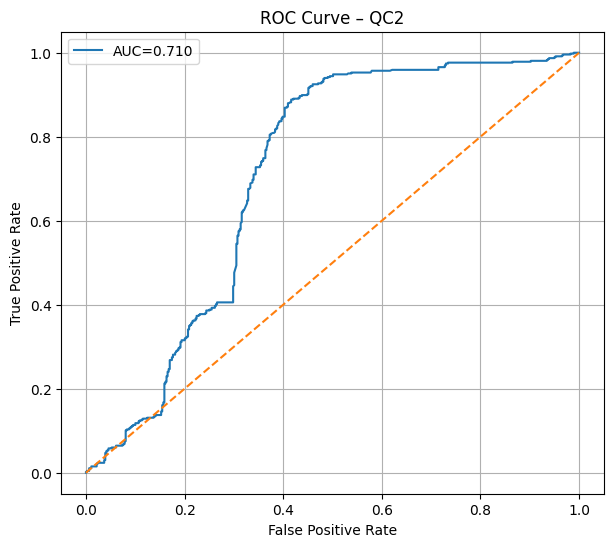

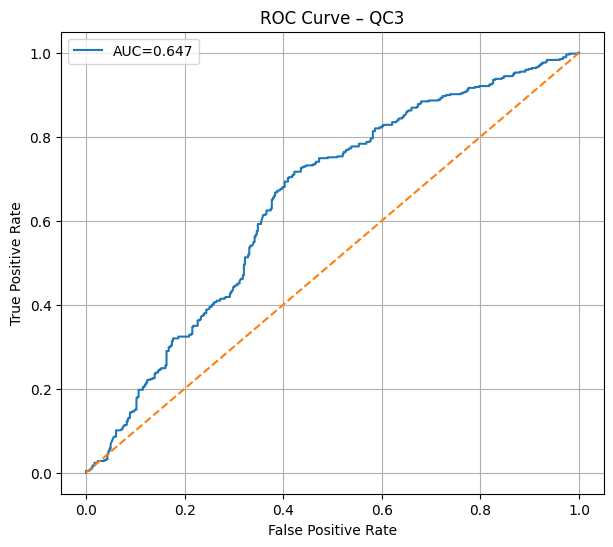

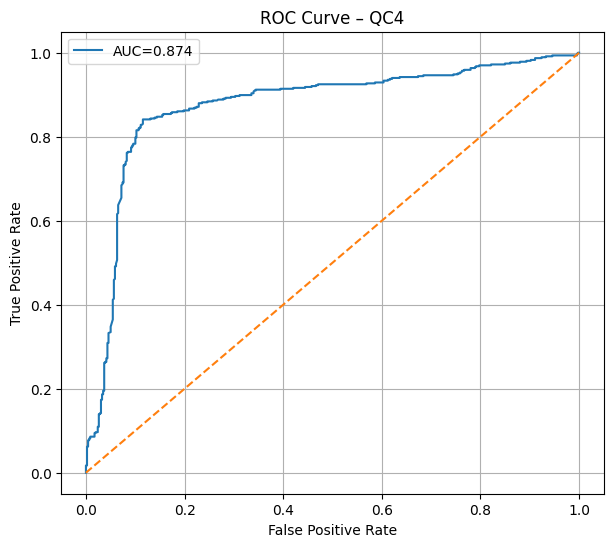

In [5]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

# ----- Evaluation function -----
def evaluate_model(model, dataloader, num_classes):
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)

            outputs = model(b_input_ids, b_input_mask)

            all_logits.append(outputs.cpu())
            all_labels.append(b_labels)

    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()

    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    # ---- Metrics ----
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    sensitivity = recall_score(labels, preds, average="macro")  # Recall
    f1 = f1_score(labels, preds, average="macro")

    # ---- Specificity ----
    cm = confusion_matrix(labels, preds)
    specificity_per_class = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity_per_class.append(tn / (tn + fp + 1e-9))
    specificity = np.mean(specificity_per_class)

    # ---- AUC ----
    if num_classes == 2:
        auc = roc_auc_score(labels, probs[:, 1])  # binary case
    else:
        labels_bin = label_binarize(labels, classes=list(range(num_classes)))
        auc = roc_auc_score(labels_bin, probs, average="macro", multi_class="ovr")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "f1": f1,
        "auc": auc,
        "labels": labels,
        "probs": probs
    }

# ----- Number of classes -----
num_classes = len(torch.unique(train_data.tensors[2]))  # or 2 for binary

best_models_results = {}

# ----- Evaluate each best model -----
for qc_name, res in final_results.items():
    print(f"\nEvaluating BEST model for {qc_name}")

    params = res["best_params"]

    # Fresh model
    model = QBiLSTM(QUANTUM_CIRCUITS[qc_name]).to(device)

    train_loader = DataLoader(
        train_data,
        sampler=RandomSampler(train_data),
        batch_size=params["batch_size"]
    )

    val_loader = DataLoader(
        val_data,
        sampler=SequentialSampler(val_data),
        batch_size=params["batch_size"]
    )

    optimizer = get_optimizer(params["optimizer"], model.parameters(), params["learning_rate"])
    loss_fn = nn.CrossEntropyLoss()

    # ---- Retrain ----
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_input_mask)
            loss = loss_fn(outputs, b_labels)
            loss.backward()
            optimizer.step()

    # ---- Final Evaluation ----
    metrics = evaluate_model(model, val_loader, num_classes)
    best_models_results[qc_name] = metrics

# ----- Print Summary Table -----
print("\n===== FINAL PERFORMANCE COMPARISON =====")
print("Model | Accuracy | Precision | Sensitivity | Specificity | F1 | AUC")
print("-"*75)
for qc, m in best_models_results.items():
    print(f"{qc} | {m['accuracy']:.4f} | {m['precision']:.4f} | {m['sensitivity']:.4f} | {m['specificity']:.4f} | {m['f1']:.4f} | {m['auc']:.4f}")

# ----- Plot ROC Curves -----
for qc, m in best_models_results.items():
    labels = m["labels"]
    probs = m["probs"]

    plt.figure(figsize=(7,6))
    if num_classes == 2:
        fpr, tpr, _ = roc_curve(labels, probs[:,1])
        auc_score = roc_auc_score(labels, probs[:,1])
        plt.plot(fpr, tpr, label=f"AUC={auc_score:.3f}")
    else:
        labels_bin = label_binarize(labels, classes=list(range(num_classes)))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
            auc_i = roc_auc_score(labels_bin[:, i], probs[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc_i:.3f})")

    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {qc}")
    plt.legend()
    plt.grid(True)
    plt.show()